<a href="https://colab.research.google.com/github/starirene9/DeepLearningAssignment/blob/main/K2024504%EA%B5%AC%EB%B9%9B%EB%82%98_Cifar100%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MobileNetV2와 ResNet18로 CIFAR-100 이미지 분류하기
- 데이터셋 : CIFAR-100
- MobileNetV2에 Dropout 추가 vs ResNet18 모델 비교
- Matplotlib으로 학습 시각화 및 두 모델의 정확도와 손실 비교

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# -----------------------
# 하이퍼파라미터
# -----------------------
learning_rate = 0.001
epochs = 5
batch_size = 100
dropout_rate = 0.2

In [4]:
# -----------------------
# 데이터 전처리
# -----------------------
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

cifar100 connectionRefusedError : [Errno 111]로 수동으로 Keras에서 cifar100-32 를 다운받아 파일을 불러오는 형태로 진행

In [5]:
from google.colab import files
uploaded = files.upload()


Saving cifar100-32.zip to cifar100-32.zip


In [7]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/cifar100-32.zip" /content/

# 압축 해제
!unzip /content/cifar100-32.zip -d /content/data/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data/cifar100-32/train/class8/img16402.png  
  inflating: /content/data/__MACOSX/cifar100-32/train/class8/._img16402.png  
  inflating: /content/data/cifar100-32/train/class8/img10098.png  
  inflating: /content/data/__MACOSX/cifar100-32/train/class8/._img10098.png  
  inflating: /content/data/cifar100-32/train/class8/img24467.png  
  inflating: /content/data/__MACOSX/cifar100-32/train/class8/._img24467.png  
  inflating: /content/data/cifar100-32/train/class1/img39375.png  
  inflating: /content/data/__MACOSX/cifar100-32/train/class1/._img39375.png  
  inflating: /content/data/cifar100-32/train/class1/img41543.png  
  inflating: /content/data/__MACOSX/cifar100-32/train/class1/._img41543.png  
  inflating: /content/data/cifar100-32/train/class1/img28293.png  
  inflating: /content/data/__MACOSX/cifar100-32/train/class1/._img28293.png  
  inflating: /content/data/cifar100-32/train/class1/img643.png  
  inflating: /content/data/__

In [8]:
# train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
# test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# 수동 압축해제된 경로 기준으로 CIFAR-100 불러오기
train_data = datasets.ImageFolder(root='/content/data/cifar100-32/train', transform=transform_train)
test_data = datasets.ImageFolder(root='/content/data/cifar100-32/test', transform=transform_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
# -----------------------
# Inverted Residual Block
# -----------------------
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = stride == 1 and in_channels == out_channels

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Dropout(p=dropout_rate),  # Dropout 추가
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [10]:
# -----------------------
# MobileNetV2 모델 정의
# -----------------------
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=100):
        super(MobileNetV2, self).__init__()
        self.cfgs = [
            [1, 16, 1, 1],
            [6, 24, 2, 1],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = 32
        self.stem = nn.Sequential(
            nn.Conv2d(3, input_channel, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True)
        )

        layers = []
        for t, c, n, s in self.cfgs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(input_channel, c, stride, expand_ratio=t))
                input_channel = c
        self.features = nn.Sequential(*layers)

        self.last_conv = nn.Sequential(
            nn.Conv2d(input_channel, 1280, 1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.last_conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Dropout 추가
        x = self.classifier(x)
        return x

In [11]:
# -----------------------
# 학습 루프
# -----------------------
model = MobileNetV2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            total += Y.size(0)
            correct += (predicted == Y).sum().item()
    test_acc = correct / total
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1}] Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")


[Epoch 1] Loss: 4.1532 | Train Acc: 5.65% | Test Acc: 4.49%
[Epoch 2] Loss: 3.6170 | Train Acc: 13.37% | Test Acc: 11.09%
[Epoch 3] Loss: 3.3285 | Train Acc: 18.33% | Test Acc: 16.93%
[Epoch 4] Loss: 3.1227 | Train Acc: 22.17% | Test Acc: 24.47%
[Epoch 5] Loss: 2.9298 | Train Acc: 25.90% | Test Acc: 27.72%


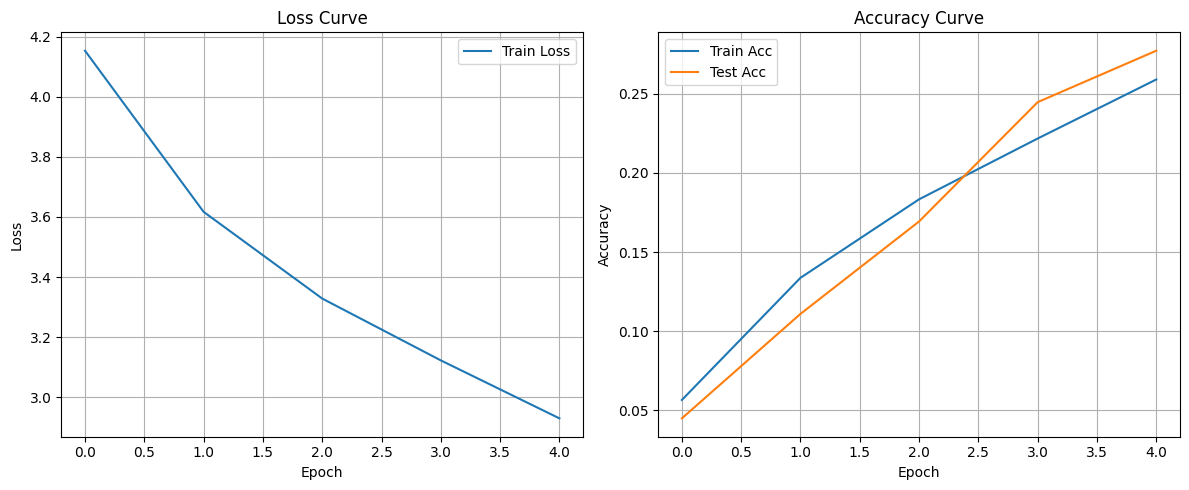

In [12]:
# -----------------------
# 학습 결과 시각화
# -----------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(test_accuracies, label='Test Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

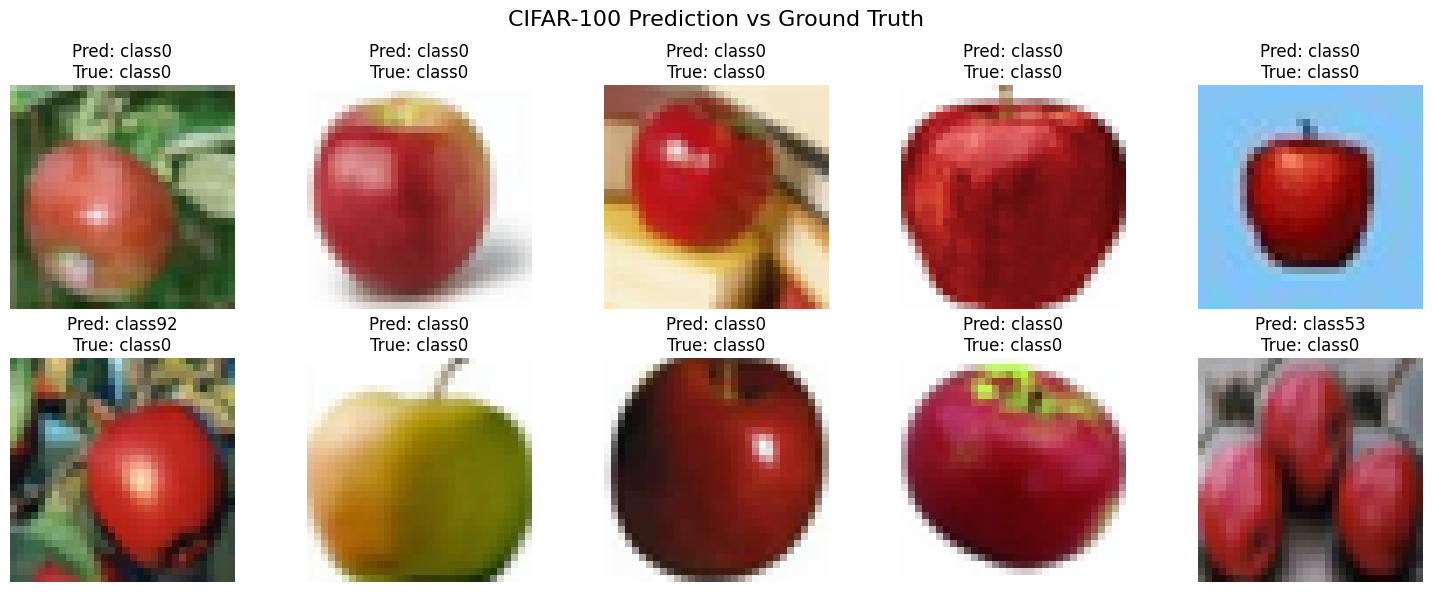

In [13]:
import numpy as np
import torchvision

# 클래스 이름 가져오기
class_names = train_data.classes  # CIFAR-100은 100개 클래스가 있음

# 모델을 평가 모드로 전환
model.eval()

# 테스트셋에서 배치 하나만 가져오기
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

# 모델 예측
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# 이미지를 CPU로 옮기고 정규화 복원
def imshow(img):
    img = img.cpu().numpy()
    img = img.transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean  # 정규화 복원
    img = np.clip(img, 0, 1)
    return img

# 시각화 (처음 10개만)
plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(imshow(images[i]))
    plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
    plt.axis('off')

plt.suptitle("CIFAR-100 Prediction vs Ground Truth", fontsize=16)
plt.tight_layout()
plt.show()


# MobileNet 비교 대상인 ResNet18 모델 정의

In [14]:
# -----------------------
# ResNet18 모델 정의
# -----------------------
import torchvision.models as models

class ResNet18Modified(nn.Module):
    def __init__(self, num_classes=100, dropout_rate=0.2):
        super(ResNet18Modified, self).__init__()
        self.base = models.resnet18(weights=None)
        self.base.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.base.maxpool = nn.Identity()
        in_features = self.base.fc.in_features
        self.base.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base(x)


In [16]:
# -----------------------
# ResNet18 모델 학습
# -----------------------
resnetModel = ResNet18Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnetModel.parameters(), lr=learning_rate)

resnet_train_losses = []
resnet_train_accuracies = []
resnet_test_accuracies = []

for epoch in range(epochs):
    resnetModel.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        outputs = resnetModel(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    resnet_train_losses.append(train_loss)
    resnet_train_accuracies.append(train_acc)

    # Evaluate on test set
    resnetModel.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            outputs = resnetModel(X)
            _, predicted = torch.max(outputs, 1)
            total += Y.size(0)
            correct += (predicted == Y).sum().item()
    test_acc = correct / total
    resnet_test_accuracies.append(test_acc)

    print(f"[ResNet Epoch {epoch+1}] Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")


[ResNet Epoch 1] Loss: 3.7246 | Train Acc: 12.69% | Test Acc: 19.81%
[ResNet Epoch 2] Loss: 2.9301 | Train Acc: 25.74% | Test Acc: 31.01%
[ResNet Epoch 3] Loss: 2.4291 | Train Acc: 35.78% | Test Acc: 38.05%
[ResNet Epoch 4] Loss: 2.0691 | Train Acc: 43.61% | Test Acc: 43.19%
[ResNet Epoch 5] Loss: 1.8275 | Train Acc: 49.32% | Test Acc: 47.81%


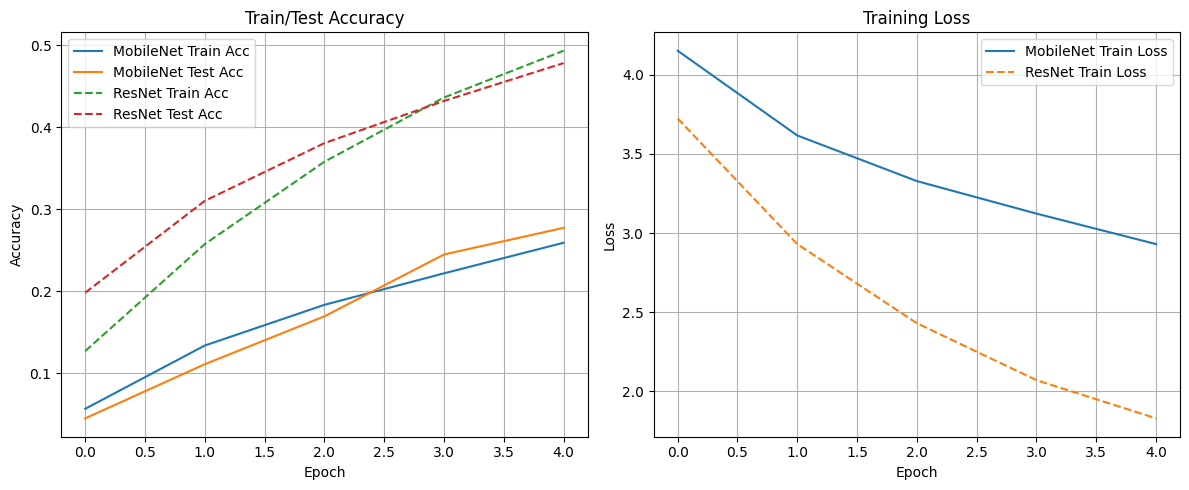

In [17]:
# -----------------------
# 5epoch일때 MobileNet vs ResNet Train/Test 정확도와 손실 시각화
# -----------------------
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='MobileNet Train Acc')
plt.plot(test_accuracies, label='MobileNet Test Acc')
plt.plot(resnet_train_accuracies, label='ResNet Train Acc', linestyle='--')
plt.plot(resnet_test_accuracies, label='ResNet Test Acc', linestyle='--')
plt.title("Train/Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='MobileNet Train Loss')
plt.plot(resnet_train_losses, label='ResNet Train Loss', linestyle='--')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


epoch을 5회 정도 밖에 돌리지 못하였으나, cifar100을 MobileNet과 ResNet 모델을 비교 대상으로 두고 실험했을때 손실과 정확도에 관해 위와 같은 시각화된 결과물을 보였다.

MobileNetV2 구조는 경량화된 모델로, InvertedResidual 블록과 DepthwiseConv를 활용해 연산량을 줄인다.

ResNet18Modified 구조는 더 깊고 강력한 표현력을 가지며, CIFAR에 맞춰 conv1 크기를 줄이고 maxpool을 제거해 특화 조정된 것으로 보인다.

실험 결과, CIFAR-100처럼 복잡하고 클래스가 많은 데이터셋에서는 ResNet18이 MobileNet보다 더 우수한 성능을 보이는 경향을 시각적으로 확인할 수 있다.